<a href="https://colab.research.google.com/github/AUT-Student/CN-HW1/blob/main/ComplexNetwork_HW1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Complex Network
<br>
<b>Description:</b> HomeWork 1 | Question 1
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Data Class

In [ ]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Edge():
  """ This class stores data of an unweighted and undirected edge
  
  Args:
    source: The source of an edge
    destination: The destination of an edge

  Note: Because of undirected manner, the source and the destination can be swap. 
  """
  source: int
  destination: int

  def __eq__(self, other):
    return (self.source == other.source and self.destination == other.destination) or\
           (self.destination == other.source and self.source == other.destination)


In [ ]:
class Graph():
  """ This class stores data of a unweighted and undirected graph. Furtermore some functions defines here"""
  def __init__(self):
    self.nodes = set()
    self.edges = set()
    self.neighbour_set = dict()

  def add_node(self, node):
    self.nodes.add(node)

    if node not in self.neighbour_set:
      self.neighbour_set[node] = set()

  def add_edge(self, edge:Edge):
    self.add_node(edge.source)
    self.add_node(edge.destination)

    self.neighbour_set[edge.source].add(edge.destination)
    self.neighbour_set[edge.destination].add(edge.source)
    self.edges.add(edge)

  def remove_edge(self, edge:Edge):
    self.neighbour_set[edge.source].remove(edge.destination)
    self.neighbour_set[edge.destination].remove(edge.source)
    self.edges.remove(edge)

  def is_exist(self, edge:Edge):
    return edge in self.edges

  def get_number_nodes(self):
    return len(self.nodes)

  def get_number_edges(self):
    return len(self.edges)

  def get_cluster_coefficient_node(self, node):
    neighbours = self.neighbour_set[node]

    k_node = len(neighbours)
    e_node = 0

    if k_node <= 1: return 0

    for n1 in neighbours:
      for n2 in neighbours:
        if n1 < n2:
          if self.is_exist(Edge(n1, n2)):
            e_node += 1
    
    return (2 * e_node) / (k_node * (k_node - 1))

  def get_cluster_coefficient(self):
    sum = 0
    for node in self.nodes:
      cluster_coefficient = self.get_cluster_coefficient_node(node)
      sum += cluster_coefficient
    
    return sum / len(self.nodes)

  def get_node_degree_list(self):
    node_degree_list = []
    for node in self.nodes:
      node_degree = len(self.neighbour_set[node])
      node_degree_list.append(node_degree)
    return node_degree_list

# Graph Generation

In [ ]:
import random

class ErdosRenyiGraph(Graph):
  """ Graph generator for Erdos Renyi Graph
  
  Args:
    number_nodes: The requested number of nodes.
    number_edges: The requested number of edges.
  """
  def __init__(self, number_nodes, number_edges):
    super().__init__()
    self.number_nodes = number_nodes
    self.number_edges = number_edges

  def generate(self):
    for i in range(self.number_nodes):
      self.add_node(i)

    all_possible_edges = []
    
    for node1 in range(self.number_nodes):
      for node2 in range(node1+1, self.number_nodes):
        all_possible_edges.append(Edge(node1, node2))
    
    selected_edges = random.sample(all_possible_edges, self.number_edges)
    for edge in selected_edges:
      self.add_edge(edge)


In [ ]:
import random

class SmallWorldGraph(Graph):
    """ Graph generator for Erdos Renyi Graph
    
    Args:
      number_nodes: The requested number of nodes.
      number_edges: The requested number of edges.
      random_prob: The random probability for changing the destination of an edge
    """

  def __init__(self, number_nodes, number_edges, random_prob):
    super().__init__()
    self.number_nodes = number_nodes
    self.number_edges = number_edges
    self.scale = self.number_edges / self.number_nodes
    self.random_prob = random_prob

  def random_change(self, number_random):
    remove_edges = random.sample(self.edges, number_random)
    source_edges_remove = list()
    for edge in remove_edges:
      self.remove_edge(edge)
      source_edges_remove.append(edge.source)

    source_edges_remove = random.sample(source_edges_remove, self.number_edges - self.get_number_edges())

    all_nodes = list(self.nodes)
    for node1 in source_edges_remove:
      while True:
        node2 = random.choice(all_nodes)
        edge = Edge(node1, node2)
        if node2 != node1 and not self.is_exist(edge):
          self.add_edge(edge)
          break

  def generate(self):
    for i in range(self.number_nodes):
      self.add_node(i)

    # The number edges for each node
    number_edges1 = int(self.scale)

    # Handling float part of expected node degree
    number_edges2 = int((self.scale - int(self.scale))*100 + 1)
    
    counter1 = 0
    counter2 = 0
    
    for node1 in range(self.number_nodes):
      for distance in range(1, number_edges1+1):
        node2 = (node1 + distance)%self.number_nodes
        self.add_edge(Edge(node1, node2))
        counter1 += 1

      if (node1 %100) < number_edges2:
        node2 = (node1 + number_edges1 + 1)%self.number_nodes
        self.add_edge(Edge(node1, node2))
        counter2 += 1

    number_random = int((self.get_number_edges() - self.number_edges) +\
                          self.random_prob * self.get_number_edges())
    
    self.random_change(number_random = number_random)

In [ ]:
import pandas as pd

class LastfmGraph(Graph):
    """ Graph loader for LastFM Asia Social Network as a complex network
    
    Refrence: https://snap.stanford.edu/data/feather-lastfm-social.html 
    """
  def __init__(self):
    super().__init__()
    self._load_data()

  def _load_data(self):
    !gdown https://snap.stanford.edu/data/lastfm_asia.zip &1>/dev/null
    !unzip  -n /content/lastfm_asia.zip

    lastfm_dataset = pd.read_csv("/content/lasftm_asia/lastfm_asia_edges.csv")

    for i, data in lastfm_dataset.iterrows():
      node1 = data["node_1"]
      node2 = data["node_2"]

      self.add_edge(Edge(node1, node2))

# Create Graphs

In [ ]:
lastfm_graph = LastfmGraph()

Downloading...
From: https://snap.stanford.edu/data/lastfm_asia.zip
To: /content/lastfm_asia.zip
100% 6.53M/6.53M [00:04<00:00, 1.47MB/s]
Archive:  /content/lastfm_asia.zip


In [ ]:
er_graph = ErdosRenyiGraph(number_nodes=7624, number_edges=27806)

In [ ]:
er_graph.generate()

In [ ]:
small_world_graph = SmallWorldGraph(number_nodes=7624, number_edges=27806, random_prob=0.05)

In [ ]:
small_world_graph.generate()

# Digree Distribution

In [ ]:
lastfm_graph_degree_list = lastfm_graph.get_node_degree_list()
small_world_graph_degree_list = small_world_graph.get_node_degree_list()
er_degree_list = er_graph.get_node_degree_list()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


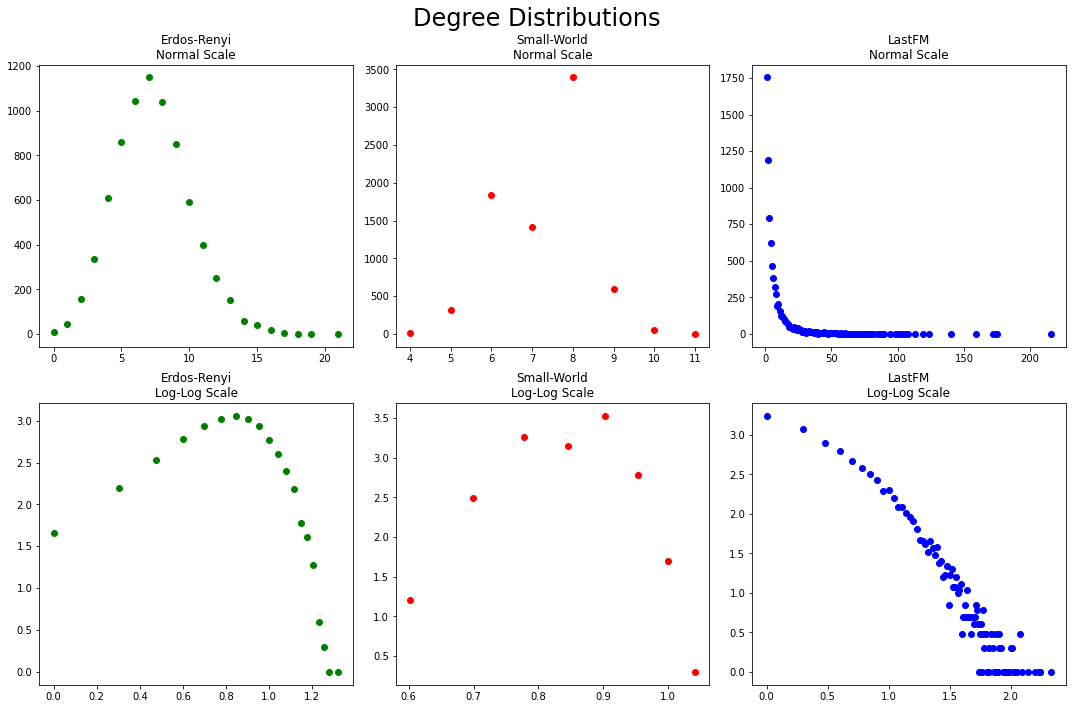

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

degree_lists = [er_degree_list, small_world_graph_degree_list, lastfm_graph_degree_list]
titles = ["Erdos-Renyi", "Small-World", "LastFM"]
colors = ["green", "red", "blue"]

fig, ax = plt.subplots(2,3)

for i in range(3):

  degree_dict = dict()
  for degree in degree_lists[i]:
    if degree not in degree_dict: degree_dict[degree] = 0
    degree_dict[degree] += 1

  scatter_x = []
  scatter_y = []

  for degree in degree_dict:
    scatter_x.append(degree)
    scatter_y.append(degree_dict[degree])

  # Normal Scale
  ax[0][i].scatter(scatter_x, scatter_y, c=colors[i])
  
  # Log-Log Scale
  ax[1][i].scatter(np.log10(scatter_x), np.log10(scatter_y), c=colors[i])

  ax[0][i].set_title(f"{titles[i]}\nNormal Scale")
  ax[1][i].set_title(f"{titles[i]}\nLog-Log Scale")


fig.suptitle("Degree Distributions", fontsize=24)
fig.set_size_inches(15,10)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

# Clustering Coefficient

In [ ]:
er_graph.get_cluster_coefficient()

0.0006326631425004975

In [ ]:
small_world_graph.get_cluster_coefficient()

0.5414613550434559

In [ ]:
lastfm_graph.get_cluster_coefficient()

0.21941842432708525